In [ ]:
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import cv2
import struct
import os
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Reshape, Lambda
from keras.models import load_model
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, LSTM, Dense, Conv2DTranspose
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix


In [ ]:
from google.colab import drive
gpath = drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unrar x "/content/drive/My Drive/Dataset/Depth.rar"

# Read the dataset

In [ ]:
print('Number of samples : ',len(os.listdir(path="/content/Depth/")))

Number of samples :  567


In [ ]:
# Define the path to the dataset directory MSR3dAction
dataset_path = "Depth/"
action_label_dict = {
    "a01": "High Arm Wave",
    "a02": "Horizontal Arm Wave",
    "a03": "Hammer",
    "a04": "Hand Catch",
    "a05": "Forward Punch",
    "a06": "High Throw",
    "a07": "Draw X",
    "a08": "Draw Tick",
    "a09": "Draw Circle",
    "a10": "Hand Clap",
    "a11": "Two Hand Wave",
    "a12": "Side-Boxing",
    "a13": "Bend",
    "a14": "Forward Kick",
    "a15": "Side Kick",
    "a16": "Jogging",
    "a17": "Tennis Swing",
    "a18": "Tennis Serve",
    "a19": "Golf Swing",
    "a20": "Pick Up and Throw"
}

action_label_dict = {
    "a01": 1,
    "a02": 2,
    "a03": 3,
    "a04": 4,
    "a05": 5,
    "a06": 6,
    "a07": 7,
    "a08": 8,
    "a09": 9,
    "a10": 10,
    "a11": 11,
    "a12": 12,
    "a13": 13,
    "a14": 14,
    "a15": 15,
    "a16": 16,
    "a17": 17,
    "a18": 18,
    "a19": 19,
    "a20": 20
}
action_labels = {}
activity_labels = []

num_classes = 21

activity_samples = []

max_n_frames = 0
for filename in os.listdir(dataset_path)[:100]:
    if not filename.endswith("depth.bin"):
        continue

    action_label = filename.split("_")[0]
    activity_labels.append(action_label_dict[action_label])

    # Load the depth map data from the binary file
    with open(dataset_path + filename, "rb") as f:
        i,  = struct.unpack('i', f.read(4))  # frame count
        # print(f"Frame count is {i}")
        w,  = struct.unpack('i', f.read(4))  # width
        h,  = struct.unpack('i', f.read(4))  # height

        single_activity_list = []
        # read frame by frame
        for frame in range(i):
            bytesread = f.read(w*h*4)
            depth_data = np.frombuffer(bytesread, dtype=np.uint32)
            single_depth_img = depth_data.reshape((240, 320))


            # print(single_depth_img.shape)
            single_activity_list.append(single_depth_img)

        activity_samples.append(single_activity_list)


(240, 320)


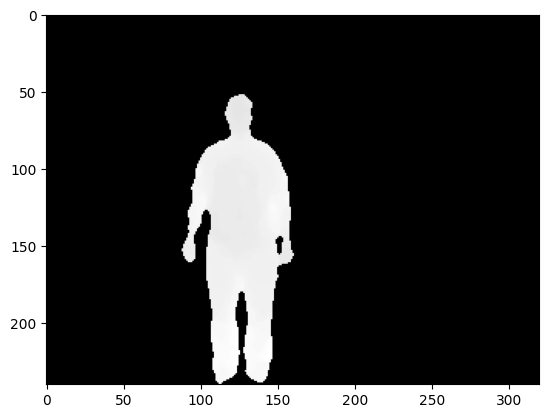

In [ ]:
print(single_activity_list[22].shape)

plt.imshow(single_activity_list[0], cmap='gray')

Now we have all depth images loaded as two-d array

----


# Sample Resizing

In [ ]:
image_sample = activity_samples[3][10]
resized_image = (cv2.resize(np.uint8(np.float32(image_sample)/1024*255), (224,224), interpolation=cv2.INTER_CUBIC))

stacked_img = np.stack((resized_image,)*3, axis=-1)

print(stacked_img.shape)



(224, 224, 3)


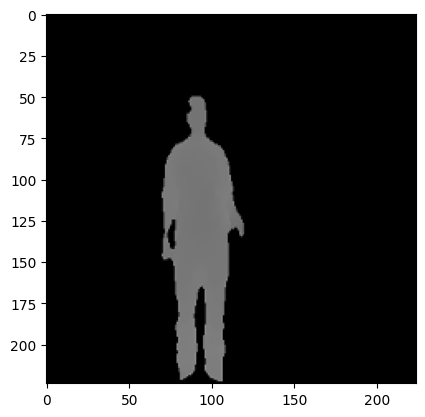

In [ ]:
plt.imshow(stacked_img, cmap='gray')


# Spatial Features

In [ ]:
import pickle
import json
from keras.applications.vgg16 import preprocess_input

#Extract image features with VGG
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input

model = VGG16()
arr = []

#do it for all images
for i in range(len(activity_samples)):
  single_act_features = []
  for j in range(len(activity_samples[i])):
    r_image = cv2.resize(np.uint8(np.float32(activity_samples[i][j])/1024*255), (224,224), interpolation=cv2.INTER_CUBIC)
    s_img = np.stack((r_image,)*3, axis=-1)
    s_img = s_img.reshape((1, s_img.shape[0], s_img.shape[1], s_img.shape[2]))
    s_img = preprocess_input(s_img)
    yhat = model.predict(s_img) ######## FEATURES ########
    single_act_features.append(yhat)

  arr.append(single_act_features)
    #activity_samples_features[i].append(yhat)

spatial_features_array = np.array(arr) ##SPATIAL FRAMES
print(spatial_features_array.shape)

#serialized_as_json = json.dumps(pickle.dumps(numpy_array).decode('latin-1'))


In [ ]:
import pickle
import json
with open("features.json", "r") as f:
  data = f.read()

deserialized_from_json = pickle.loads(json.loads(data).encode('latin-1'))
print(deserialized_from_json.shape)

(100,)


In [ ]:
samp1 = deserialized_from_json[0][0]
print(samp1.shape)

(1, 1000)


In [ ]:
print(deserialized_from_json[0])

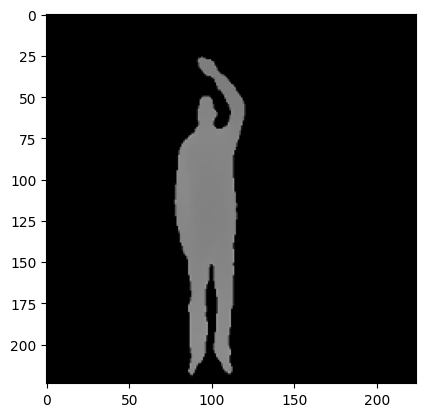

In [ ]:
plt.imshow(activity_samples[7][14], cmap='gray')

# Temporal Features

In [ ]:
def extract_temporal_features_from_frames(frame_array):
    frame_diffs = []

    prev_frame = None
    for frame in frame_array:
        if prev_frame is not None:
            frame = cv2.absdiff(frame.astype(np.uint8), prev_frame.astype(np.uint8))
            frame_diff_mean = np.mean(frame)
            frame_diffs.append(frame_diff_mean)

        prev_frame = frame

    # Transform the frame_diffs into a one-dimensional temporal feature vector
    feature_vector = np.array(frame_diffs)

    return feature_vector

# Create an array of frames (you need to replace this with your actual frame array)
frame_array = activity_samples[0]  # List of frames, where each frame is a grayscale image

# Extract temporal features from the frame array
temporal_feature_list = []
for activity in activity_samples:
  temporal_feature_vector = extract_temporal_features_from_frames(activity)
  temporal_feature_list.append(temporal_feature_vector)

print("Temporal Feature Vector:", temporal_feature_list[0])
print("Feature Vector Shape:", temporal_feature_list[0].shape)




Temporal Feature Vector: [ 0.76289063 12.28779948  1.05645833 12.49738281  2.01584635 13.1783724
  3.27950521 14.388125    5.06005208 15.18602865  5.46298177 15.15157552
  5.611875   15.31105469  5.86731771 15.8821224   6.45934896 16.35002604
  7.44520833 18.24855469  8.15582031 18.27191406  8.23486979 18.09516927
  8.46565104 17.90263021  8.8334375  17.68473958  8.89583333 17.68447917
  8.8433724  17.75731771  9.12364583 18.30153646  9.53321615 18.55316406
  9.54558594 18.3894401   9.47511719 18.27028646]
Feature Vector Shape: (40,)


In [ ]:
print("Temporal Feature Vector:", temporal_feature_list[30])
print("Feature Vector Shape:", temporal_feature_list[30].shape)


Temporal Feature Vector: [ 0.66503906 22.69117187  1.07804688 22.56268229  1.9503776  22.37460937
  2.75076823 22.2159375   4.51528646 23.03558594  5.8758724  23.35272135
  6.4959375  23.87682292  7.59332031 24.7333724   8.63446615 24.31815104
  8.88575521 24.10236979  9.31841146 24.22886719  9.62035156 24.04355469
  9.79835938 24.19861979  9.84197917]
Feature Vector Shape: (27,)




# TODO : Multiply temporal with spatial


# Feed that to MLP
